## Plotting globally distributed earthquakes on a map with equidistant projection

Feel free to modify or play around with the different parameters!

Packages required on your system:
* PyGMT (and corresponding libraries, e.g. pandas, numpy, xarray), still under development (see <https://www.pygmt.org/dev/overview.html>)
* ObsPy (see <https://github.com/obspy/obspy/wiki>)
* geographiclib

author: M. Grund (2020-04-13)

In [1]:
import pygmt
import numpy as np
import pandas as pd
import os
from obspy.geodetics.base import gps2dist_azimuth

# define foreground color that is later used for plotting
pygmt.config(COLOR_FOREGROUND = 'red3')

Earthquake data is freely available from USGS and can be easily downloaded via `pandas` (for more information on earthquake data take a look on: <https://earthquake.usgs.gov/earthquakes/map/>).

Define the time period (here 1960/01/01 to 2020/02/01), magnitude range (here 6), ordering of the requested data and build an url (`urlfin`) that can be directly handed over to pandas `read_csv` function. The requested earthquake data is then stored in `data`.

In [2]:
url = 'https://earthquake.usgs.gov/fdsnws/event/1/query.csv'
time = 'starttime=1960-01-01%2000:00:00&endtime=2020-02-01%2000:00:00'
mag = 'minmagnitude=6'
order = 'orderby=time-asc'
urlfin = url + '?' + '&'.join([time, mag, order])

# use pandas to fetch the file from the USGS webserver via the url built above
data = pd.read_csv(urlfin)

Create a new pygmt figure object.

In [3]:
fig = pygmt.Figure()

Let's start with the basic map in a global equidistant projection (`'E'`) with a horizon limit at 160° distance and a diameter of 5.8i centered at `centerE`/`centerN`. In this example the center location corresponds to the Black Forest Observatory in southwestern Germany, one of the most quiet seismic stations around the globe ;) (see <http://www.black-forest-observatory.de/>).

* Continents are plotted in gray color as defined by `colfill` (RGB values). 
* Resolution of the continents is set to `'c'` (crude) and only shorelines of the first level (coastline) are plotted with a linewidth of 0.1p (`'1/0.1p'`). See <https://www.pygmt.org/dev/tutorials/coastlines.html> for other supported resolutions and shoreline levels. 
* `C` defines the color of wet areas which is set here to the same color as the continents have, so no lakes and rivers are visible.

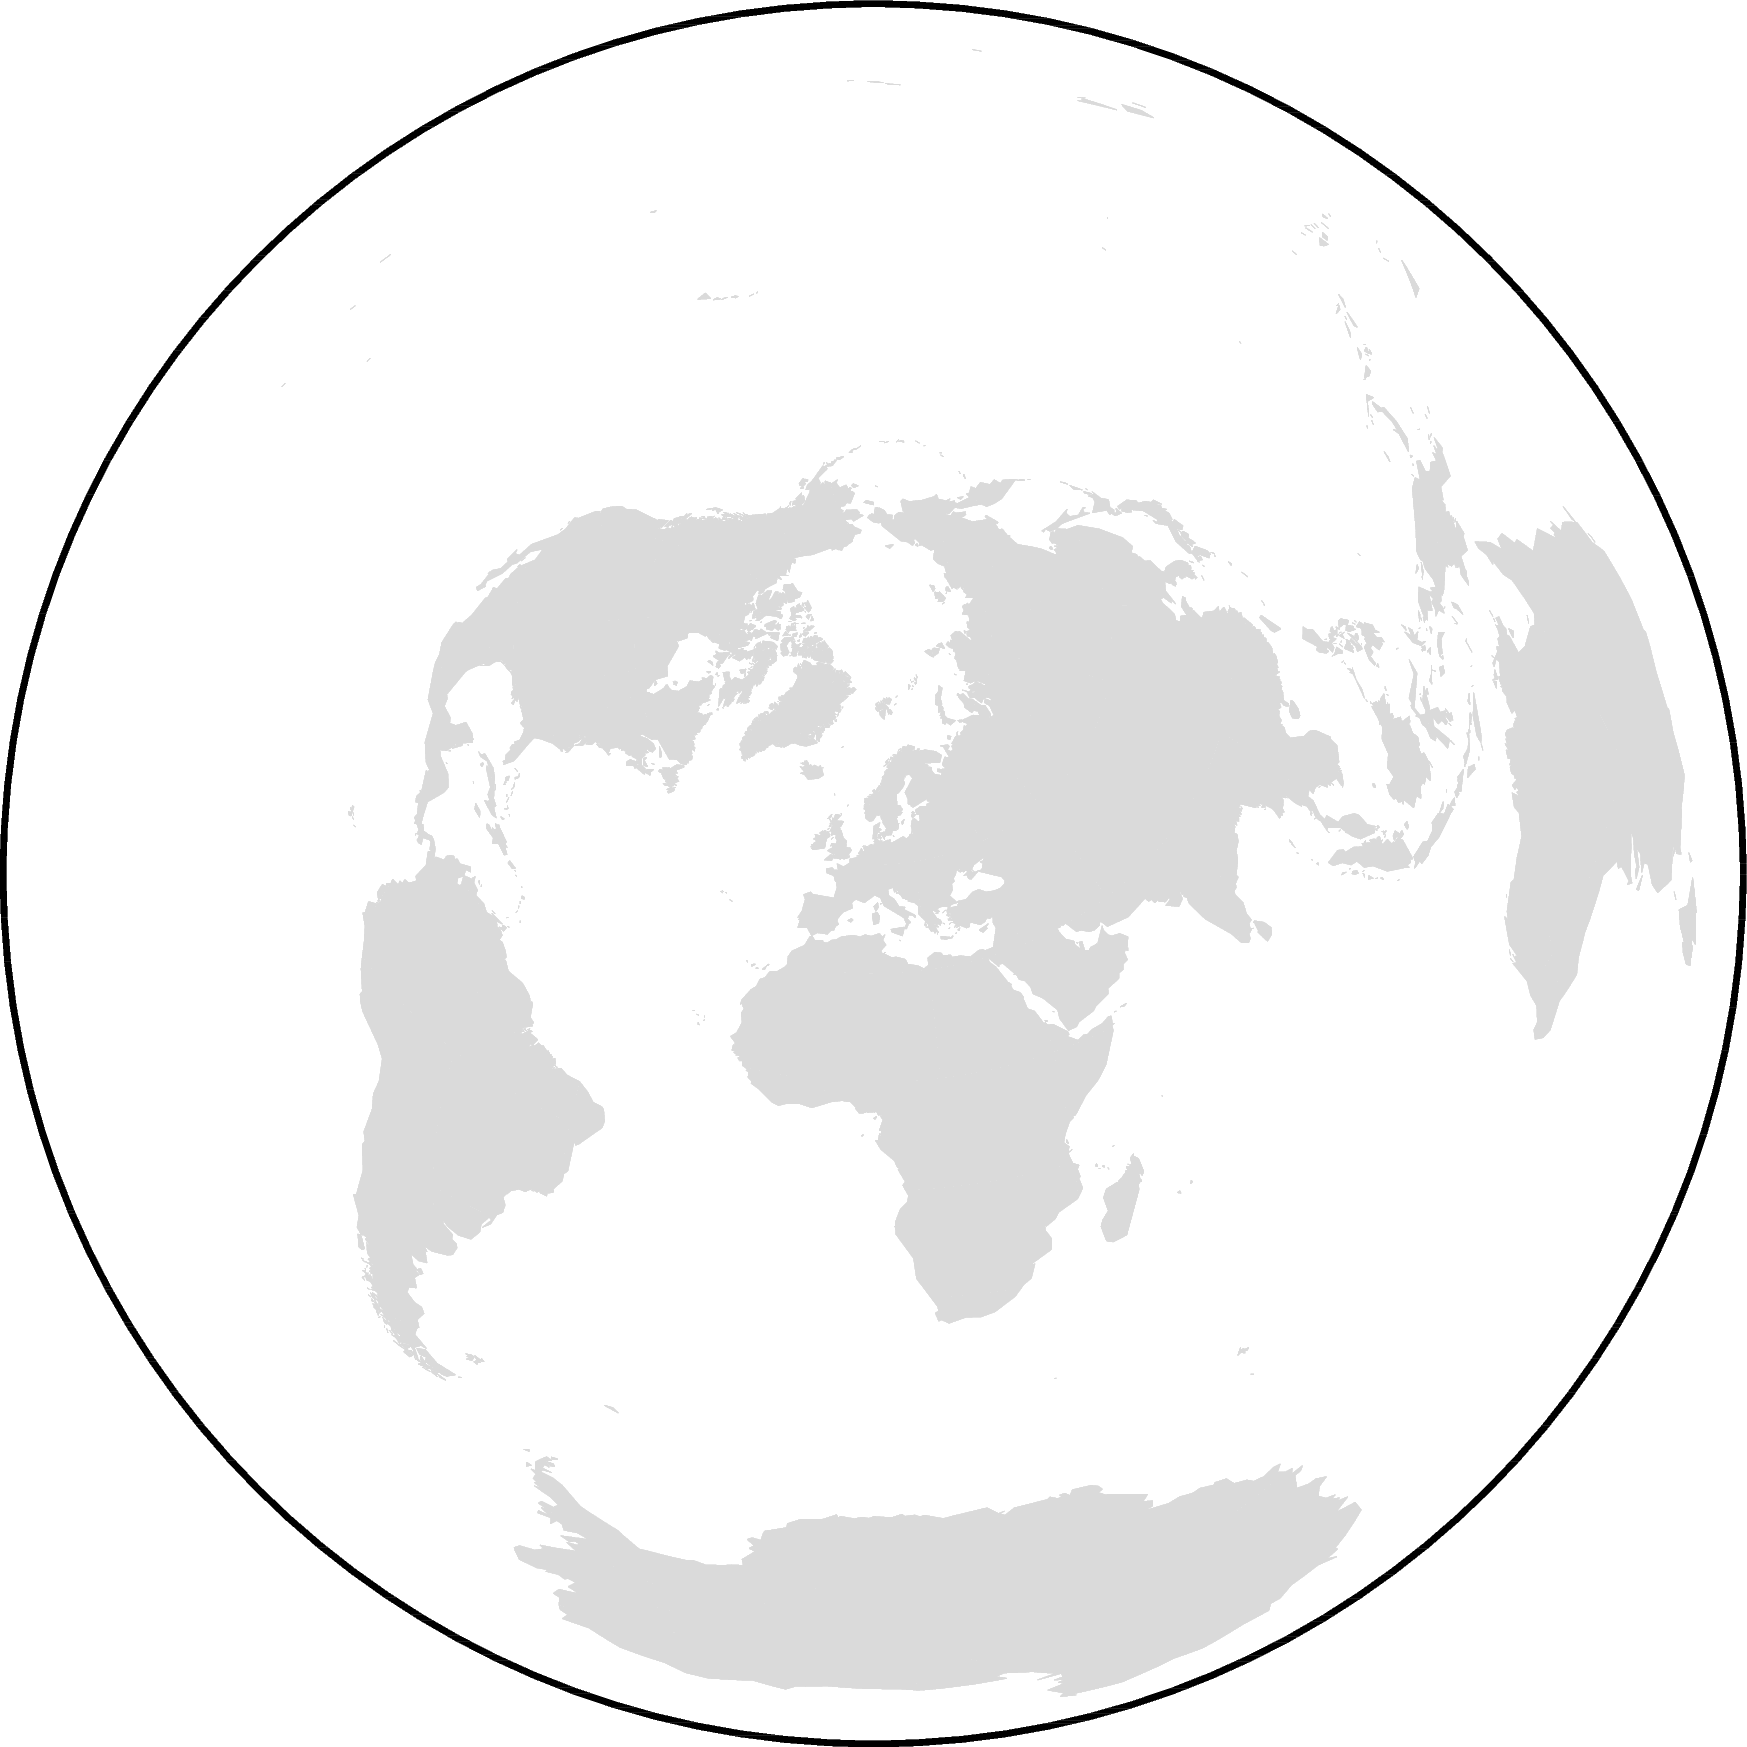

In [4]:
# center of map
centerN = 48.332 # latitude in degrees
centerE = 8.331 # longitude in degrees

colfill = '217.6/217.6/217.6'
fig.coast(region='g', projection = 'E' + str(centerE) + '/'+ str(centerN) + '/160/5.8i', \
          resolution = 'c', land = colfill, shorelines ='1/0.1p,' + colfill, C = colfill, frame = True)

fig.show()

Now let's add the following items:
* The plate boundaries after Bird (2003) as light red lines of 0.5 p thickness (`pen = '0.5p,' + plbcol`), read from a simple texfile (`data = plbfile`)
* Dashed circles within a specified distance (in °) from the map center (`distlims`)  
* A darkgray (`color = '105/105/105'`) triangle with a size of 0.65 cm (`style = 't0.65c'`) and a black edge of 0.7p thickness (`pen = '0.7p,black'`) in the map center representing e.g. a station network or a single seismic recording station

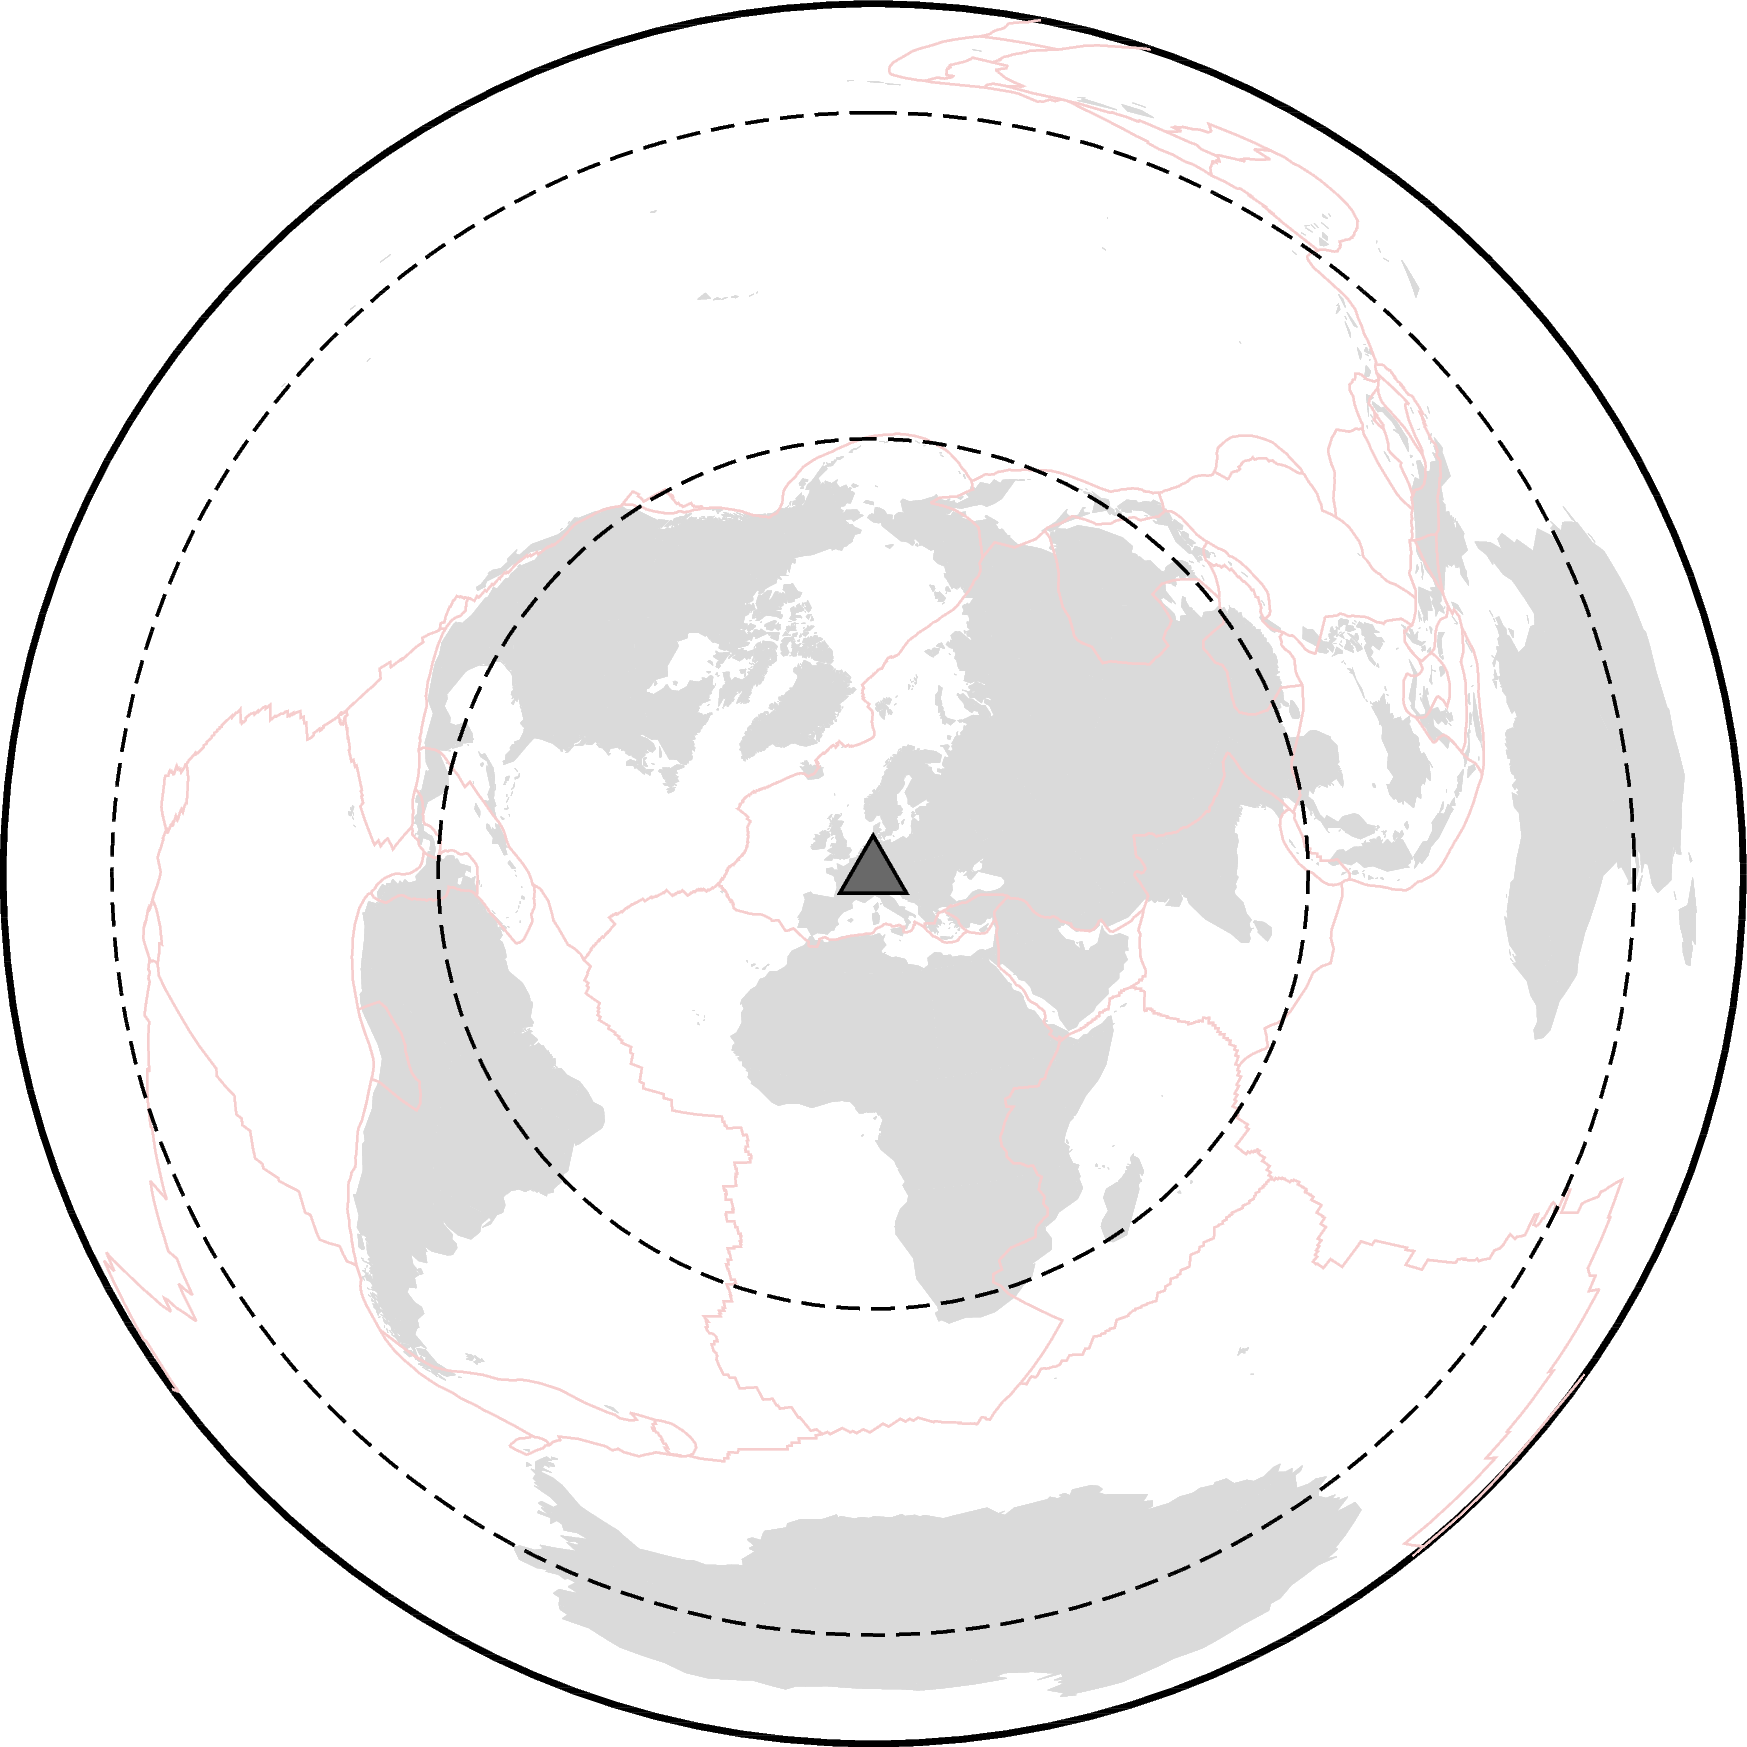

In [5]:
# plot plate boundaries after Bird (2003)
plbfile = 'PB2003_boundaries_GMTready.txt'
plbcol = '245.76/204.8/204.8'
fig.plot(data = plbfile, pen = '0.5p,' + plbcol)

# plot circles at 80 and 140 degrees distance, use here twice the value since GMT expects the diameter
distlims = [80, 140]
fig.plot(x = centerE, y = centerN, style ='E-' + str(2 * distlims[0]) + 'd', pen ='0.7p,black,--')
fig.plot(x = centerE, y = centerN, style ='E-' + str(2 * distlims[1]) + 'd', pen ='0.7p,black,--')

# plot station marker
fig.plot(x = centerE, y = centerN, color = '105/105/105', style = 't0.65c', pen ='0.7p,black')

fig.show()

* Now we first define the colormap that should be used. Here we take the continuous `viridis` colormap for events with depths between 0 and 600 km and a step size of 100 km (defined as series). The output colormap is saved as `'cmapmod.cpt'`. `M = ''` ensures that the foreground color defined in the beginning (`COLOR_FOREGROUND = 'red3'`) is used. Thus, all events located deeper than 600 km are plotted in red.

* Afterwards we first calculate the distance for each earthquake epicenter location to the map center using ObsPy's `ps2dist_azimuth` function (at a later stage of development this action may be done directly using PyGMT, look for psproject) and store only these events in `datafilt`.

* Finally, we plot the earthquake epicenters within the defined distance range, color-coded by depth and scaled by the event magnitude. 

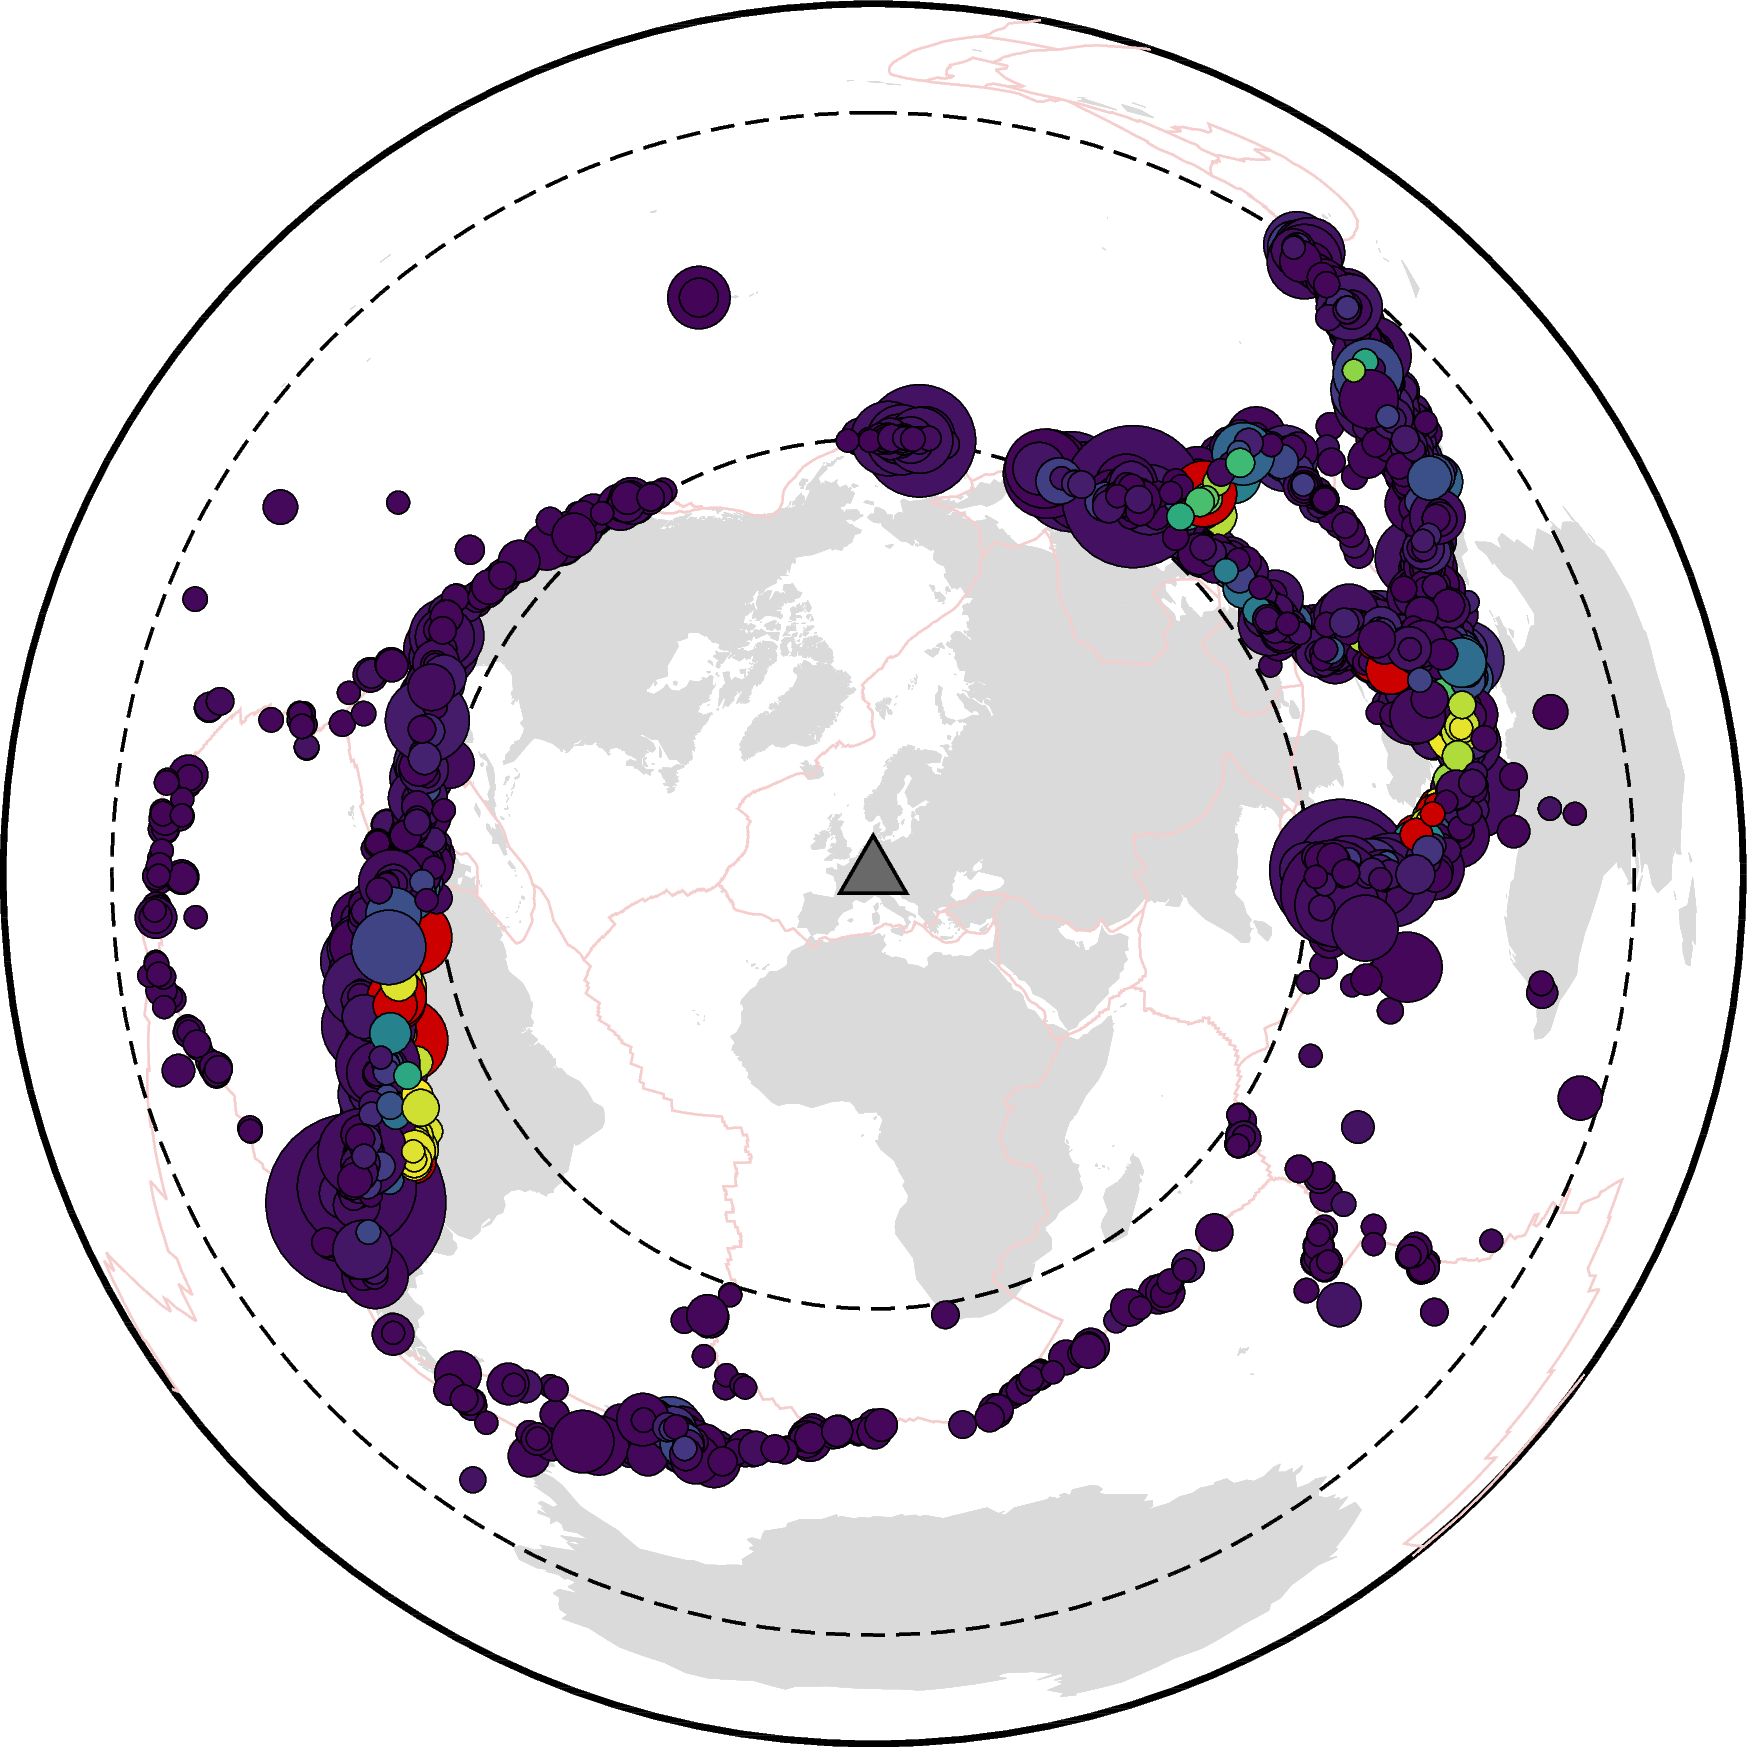

In [6]:
# Define colormap, set reverse = true if you want to reverse the colormap
pygmt.makecpt(cmap = 'viridis', reverse = False, series = [0, 600, 100], output = 'cmapmod.cpt', continuous = True,  M = '')
cwd = os.getcwd()

# calculate distance from each EQ to center of map, later this may be available in pygmt as psproject,
# instead use obspy now
data['isin'] = np.full(np.shape(data)[0], False) # generate new column in dataframe filled with False

for ii in range(0,len(data)):
    if distlims[0] < gps2dist_azimuth(centerN, centerE, data['latitude'][ii], data['longitude'][ii])[0]/111/1000 < distlims[1]:
        data.loc[ii, 'isin'] = True

# use only EQs within the given distance range     
datafilt = data[data['isin'] == True].copy()  

# plot the corresponding event locations
fig.plot(x = datafilt.longitude, y = datafilt.latitude, style = 'c' , pen = 'black',sizes = np.exp(datafilt.mag/1.7)*0.0057, \
         color = datafilt.depth, cmap = cwd + '/cmapmod.cpt')

fig.show() 

1) Plot the distance circles for the values given in `distlims` again on top in white with slight transparency (`t = '60'`). This small trick ensures that the circles are also visible when the "event circles" overlap

2) Add text to the distance circles and place a colorbar in upper left corner. 
* The position of the colorbar is 0.2 cm in x-  and 15.7 cm in y-direction direction from the origin in the lower left corner (`x0.2c/15.7c`) 
* The size is given by a width of 6.5 cm and a height of 0.45 cm (`w6.5c/0.45c`)
* The white triangle on the right-hand side of the bar is defined by `ef0.2c`
* Locating the label defined in `frame` above the colorbar is handled by `ml`
* The horizontal orientation of the colorbar is set by `h`

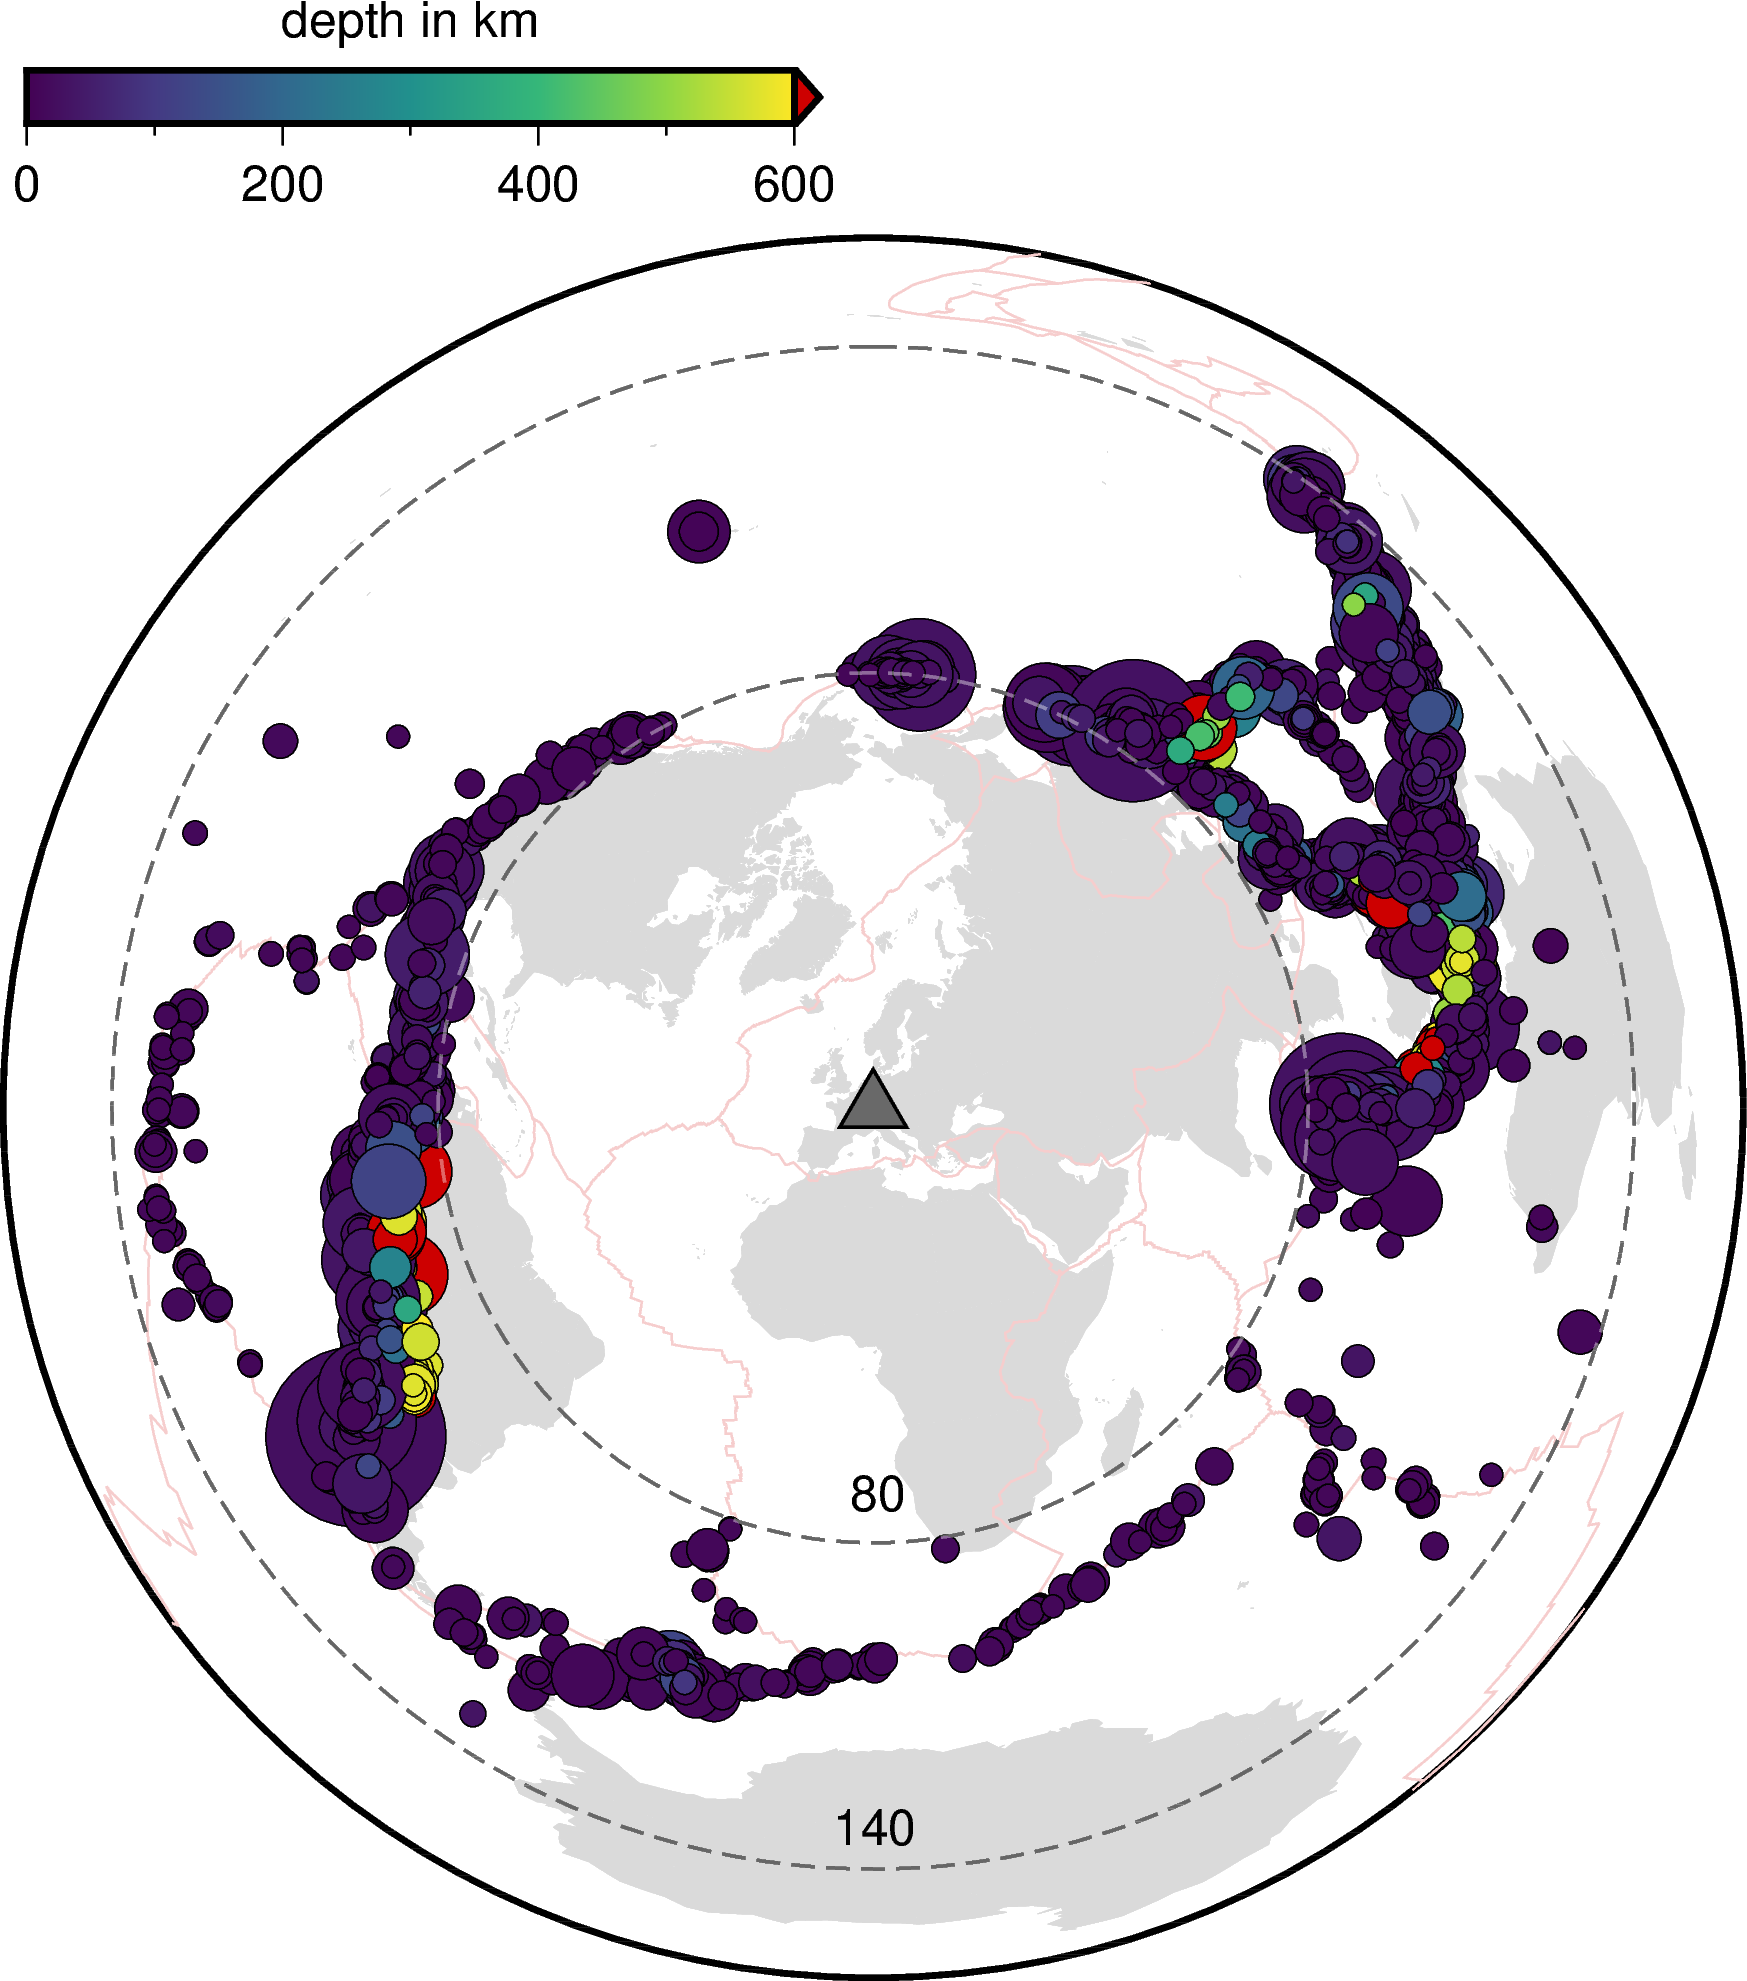

In [7]:
# plot distance circles again on top in transparent white
fig.plot(x = centerE, y = centerN, style = 'E-' + str(2 * distlims[0]) + 'd', pen ='0.7p,white,--', t = '60')
fig.plot(x = centerE, y = centerN, style = 'E-' + str(2 * distlims[1]) + 'd', pen ='0.7p,white,--', t = '60')

# plot text on circles
fig.text(x = 9 , y = -22.5 , text = '80', font = '12p')
fig.text(x = 9 , y = -84 , text = '140', font = '12p')

# set fontsize of label to '12' 
with pygmt.config(FONT_LABEL = '12'):
    fig.colorbar(cmap = cwd + '/cmapmod.cpt', position = 'x0.2c/15.7c+w6.5c/0.45c+ef0.2c+ml+h', box = False, \
        frame = ['+L"depth in km"', 'xaf'])

fig.show()

Now plot a custom legend showing the magnitudes in the figure as gray circles of different size by using another map projection.

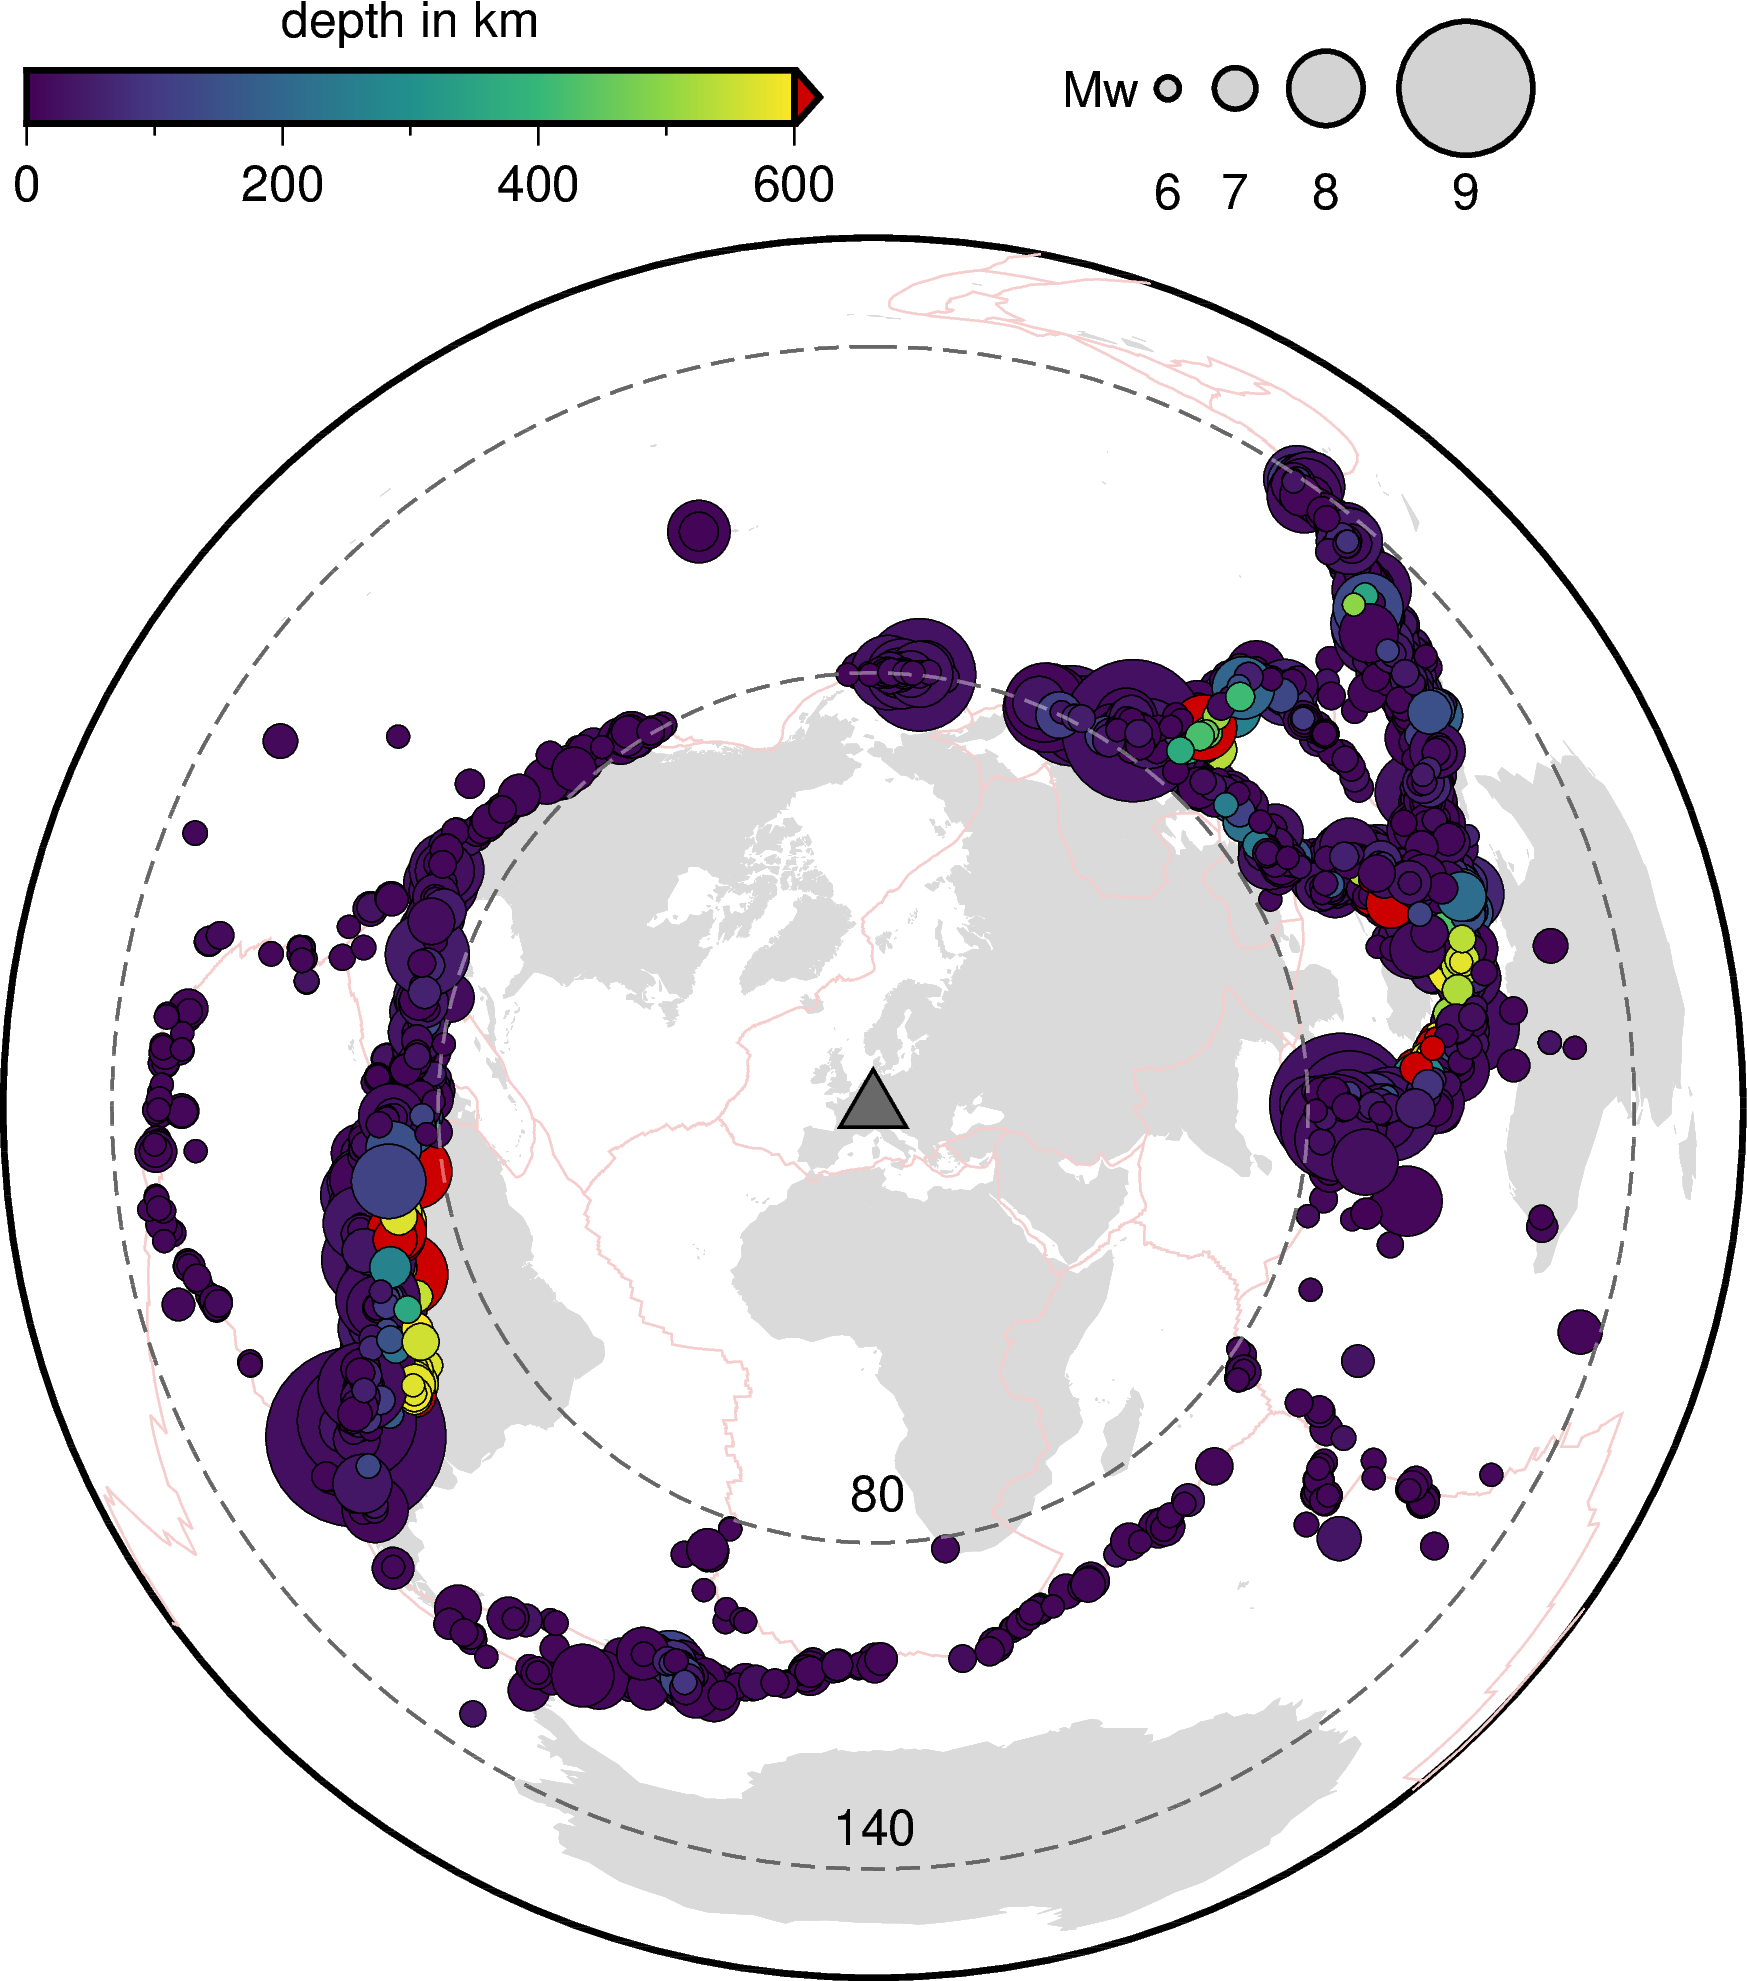

In [8]:
col_leg = 'lightgray'

fig.shift_origin(xshift = '9c', yshift = '13.2c')

# plot circles
yval1 = 18
fig.plot(region = [0,26,0,26], projection = 'M4', x = 22, y = yval1, style = 'c' + str(np.exp(9/1.7)*0.0057), pen = '1.2p,black', color = col_leg)
fig.plot(x = 14.3, y = yval1, style = 'c' + str(np.exp(8/1.7)*0.0057) , pen = '1.2p,black', color = col_leg)
fig.plot(x = 9.3, y = yval1, style = 'c' + str(np.exp(7/1.7)*0.0057) , pen = '1.2p,black', color = col_leg)
fig.plot(x = 5.6, y = yval1, style = 'c' + str(np.exp(6/1.7)*0.0057) , pen = '1.2p,black', color = col_leg)

# add annotations
yval2 = 12.5
fig.text(x = 22 , y = yval2 , text = '9', font = '12p')
fig.text(x = 14.3 , y = yval2 , text = '8', font = '12p')
fig.text(x = 9.3 , y = yval2 , text = '7', font = '12p')
fig.text(x = 5.6 , y = yval2 , text = '6', font = '12p')
fig.text(x = 1.9 , y = yval1 , text = 'Mw', font = '12p')

fig.show()

Finally, save the figure in png format.

In [9]:
fig.savefig('PLOT_EQglob_BFO.png')

### References

* Bird (2003), An updated digital model of plate boundaries, Geochemistry Geophysics Geosystems, 4(3), 1027, <https://doi.org/10.1029/2001GC000252>.